![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Automatic Ticket Assignment

### Summary of problem statement.


**Required Files given in below link.**
https://drive.google.com/file/d/1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ/view

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.constraints import maxnorm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV,GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten,Input,SpatialDropout1D,LSTM,TimeDistributed
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import PredefinedSplit
from gensim.models import KeyedVectors #word2vec
import os.path
from os import path

from io import BytesIO
from zipfile import ZipFile
import requests


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')
import time

print('tensorflow version ',tf.__version__)
print('pandas version ',pd.__version__)
print('numpy version ',np.__version__)

tensorflow version  2.3.0
pandas version  1.1.4
numpy version  1.18.5


In [4]:
#Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#let's find the current working directory
!pwd

/content


In [6]:
#change working directory to project folder.
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/NLP-AutomaticTicketAssignment/')

In [7]:
#list the directory
!ls

'Automatic Ticket Assignment Brief.pdf'   input_data.xlsx   model.bin   README
 AutomaticTicketAssignment.ipynb	  meta.json	    model.txt


In [8]:
#Set current directory data dir
data_dir = './'

In [9]:
#Class to load xls file
class XlsLoader :
  _filePath = ""
  _xlsDF = pd.DataFrame()

  def __init__(self, filePath):
    self._filePath = filePath
 
  def load_data(self):
      print("loading file {}".format(self._filePath))
      self._xlsDF = pd.read_excel(self._filePath)

  def dropField(droppedFieldName):
    return self._xlsDF.drop([droppedFieldName],axis=1)    

  def groupBy(self,columnName):
      df = self._xlsDF.groupby([columnName]).count()
      print(df)



In [10]:
#read input file from xls 
filePath = data_dir + "input_data.xlsx"
loader = XlsLoader(filePath)
loader.load_data()

loading file ./input_data.xlsx


In [11]:
loader._xlsDF.columns = ['shortdescription', 'description', 'caller', 'assignmentgroup']

In [12]:
#header of inputs
loader._xlsDF.head(5)

,shortdescription,description,caller,assignmentgroup
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [13]:
#info of input data
loader._xlsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   shortdescription  8492 non-null   object
 1   description       8499 non-null   object
 2   caller            8500 non-null   object
 3   assignmentgroup   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [14]:
loader._xlsDF.dtypes

shortdescription    object
description         object
caller              object
assignmentgroup     object
dtype: object

In [15]:
#fill N/A with "##"" characters.
loader._xlsDF = loader._xlsDF.fillna("#")

In [16]:
loader._xlsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   shortdescription  8500 non-null   object
 1   description       8500 non-null   object
 2   caller            8500 non-null   object
 3   assignmentgroup   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [17]:
loader._xlsDF.assignmentgroup.value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_73       1
GRP_64       1
GRP_70       1
GRP_35       1
GRP_67       1
Name: assignmentgroup, Length: 74, dtype: int64

In [18]:
#concat short description and description field. 
loader._xlsDF['sdesc_desc'] = loader._xlsDF['shortdescription'].astype('string') + " " + loader._xlsDF['description'].astype('string')  

In [19]:
loader._xlsDF.dtypes

shortdescription    object
description         object
caller              object
assignmentgroup     object
sdesc_desc          string
dtype: object

In [20]:
loader._xlsDF['num_words'] = loader._xlsDF.sdesc_desc.apply(lambda x : len( x.split() ))

In [21]:
loader._xlsDF.head(5)

,shortdescription,description,caller,assignmentgroup,sdesc_desc,num_words
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,login issue -verified user details.(employee# ...,35
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0,outlook received from: hmjdrvpb.komuaywn@g...,26
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0,cant log in to vpn received from: eylqgodm...,16
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page unable to access...,10
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,4


#Pre-Processing, Data Visualization and EDA
 - Exploring the given Data files
 - Understanding the structure of data
 - Missing points in data
 - Finding inconsistencies in the data
 - Visualizing different patterns
 - Visualizing different text features
 - Dealing with missing values
 - Text preprocessing
 - Creating word vocabulary from the corpus of report text data
 - Creating tokens as required

In [22]:
class Plotter :
   _xlsDF = pd.DataFrame()
   
   def __init__(self,df):
    self._xlsDF = df.copy()

   def bar_plot(self, bins , labels):
     plt.figure(figsize=(10,6))
     df = self._xlsDF
     df['bins'] = pd.cut(df.num_words, bins, labels)
     word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})
     sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

   def count_plot(self,title,columnName):
     plt.figure(figsize=(10,6))
     ax = sns.countplot(x=columnName, data=self._xlsDF)
     plt.title(title)

   def bar_plot_groupby(self, groupby, numwords):
     word_avg = self._xlsDF.groupby(groupby)[numwords].mean().plot(kind='bar', figsize=(25,15))
     plt.xlabel('desc', fontsize=20)
     plt.ylabel('Count of Words', fontsize=20)
     plt.xticks(fontsize=20)
     plt.yticks(fontsize=20)
     plt.title('Number of Words per Description Distribution', fontsize=30)
     plt.show()

   def word_cloud_plot(self, dfColumnName, word_count):
     allwords = []
     allwordsSeris = loader._xlsDF[dfColumnName].str.lower().str.split()
     for series in allwordsSeris:
       for word in series:
         allwords.append(word)         
     mostcommon = FreqDist(allwords).most_common(word_count)
     wordcloud = WordCloud(width=800, height=600, background_color='white').generate(str(mostcommon))
     fig = plt.figure(figsize=(20,10), facecolor='white')
     plt.imshow(wordcloud, interpolation="bilinear")
     plt.axis('off')
     plt.title('Top '+str(word_count)+' Most Common Words', fontsize=30)
     plt.tight_layout(pad=0)
     plt.show()

   def heat_map_plot_review_len_word_len(self ):
     loader._xlsDF['review_len'] = loader._xlsDF['sdesc_desc'].str.len()
     correlation = loader._xlsDF[['review_len','num_words']].corr()
     mask = np.zeros_like(correlation, dtype=np.bool)
     mask[np.triu_indices_from(mask)] = True
     plt.figure(figsize=(8,6))
     plt.xticks(fontsize=10)
     plt.yticks(fontsize=10)
     sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 15}, linewidths=10, vmin=-1.5, mask=mask)  


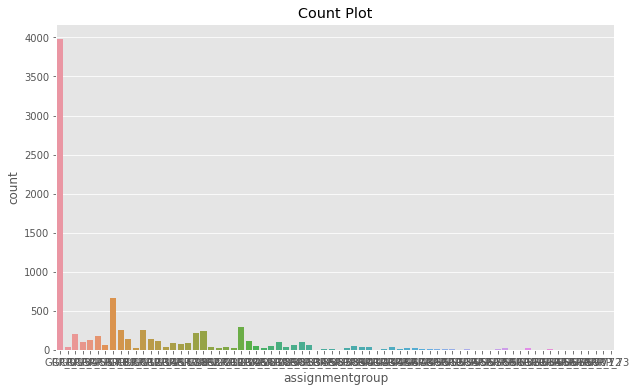

In [23]:
plotter = Plotter(loader._xlsDF)
plotter.count_plot("Count Plot","assignmentgroup")

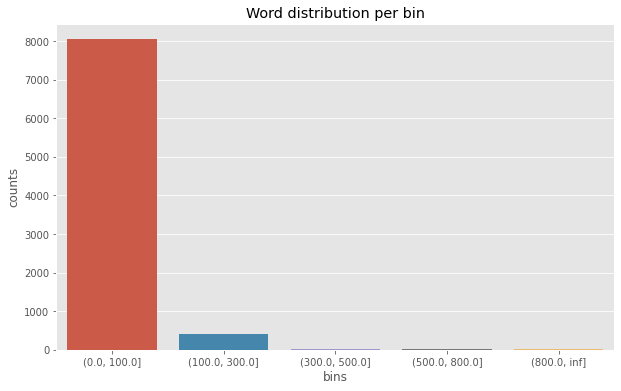

In [24]:
plotter.bar_plot(bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])

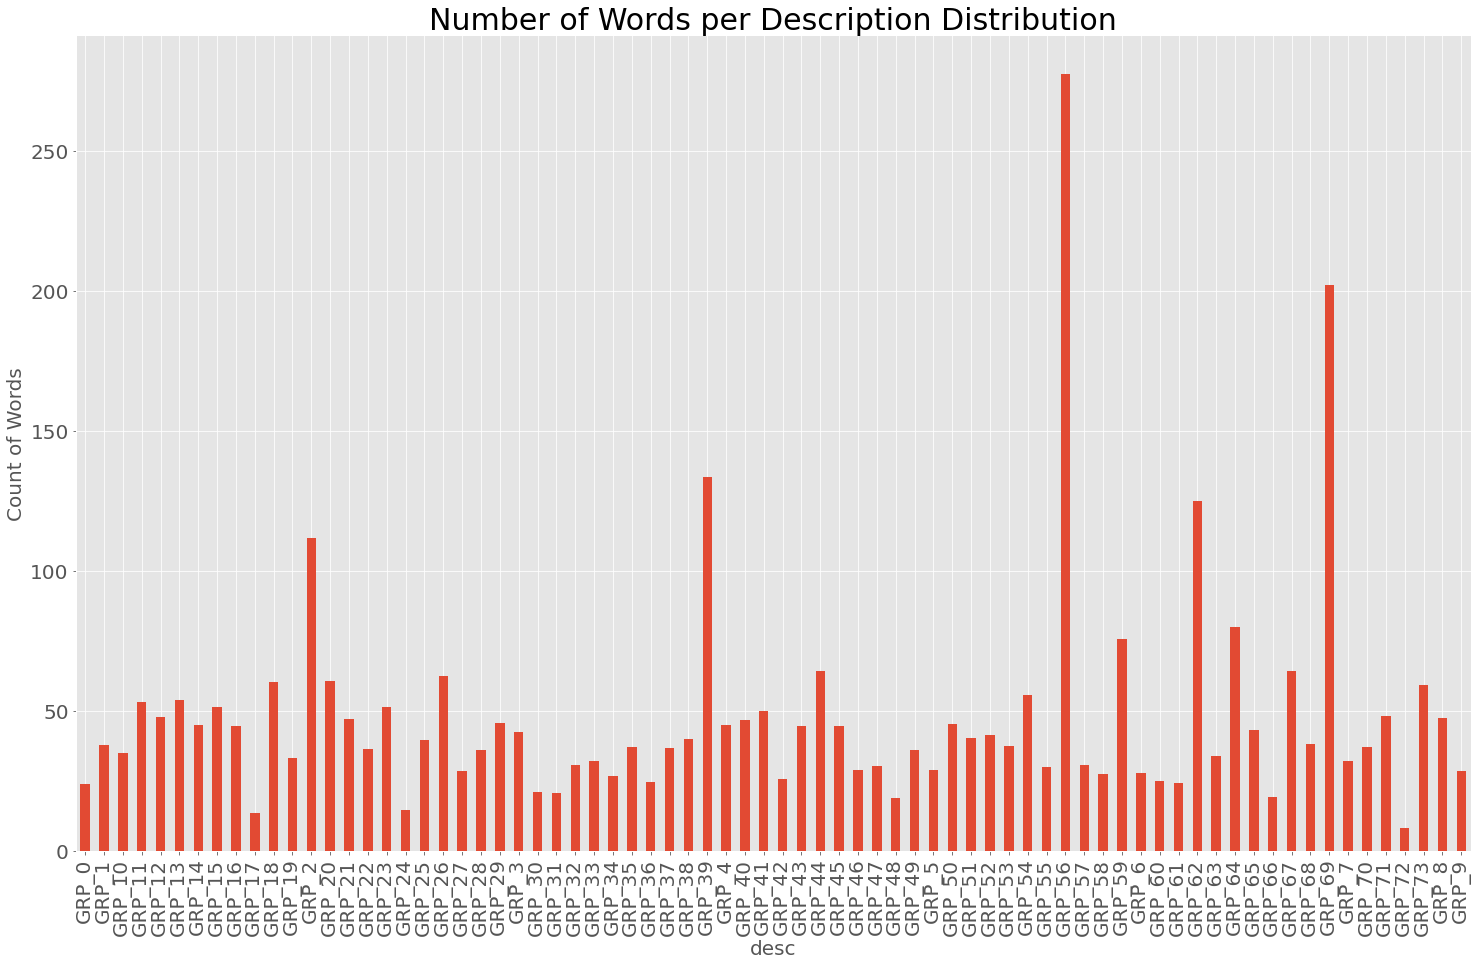

In [25]:
plotter.bar_plot_groupby('assignmentgroup','num_words')

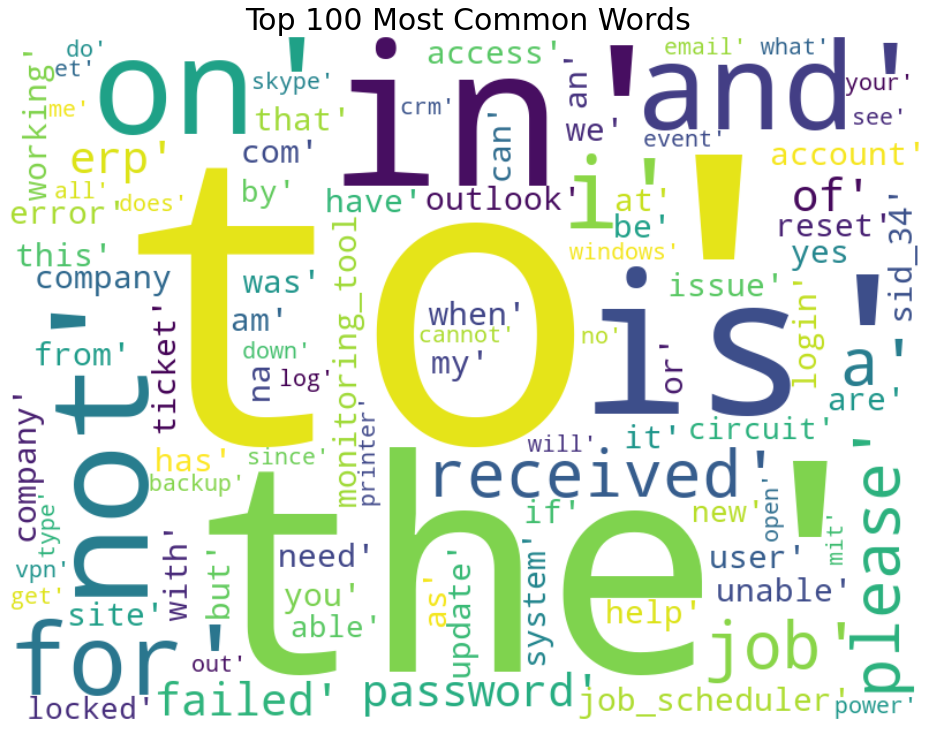

In [26]:
#calculate all words from given data
plotter.word_cloud_plot('sdesc_desc',100)

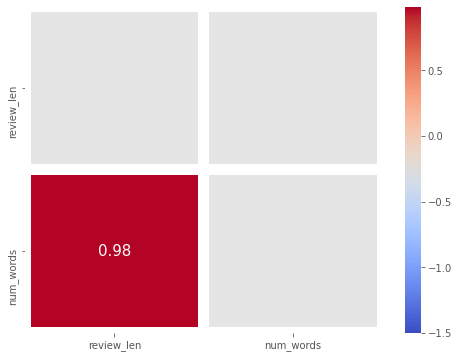

In [27]:
plotter.heat_map_plot_review_len_word_len()

In [28]:
class Preprossesing:   # TODO Need to refine input data. We need to still work on it.
  def __init__(self,df, xColName, yColName, randonmState = 42):
    self._xlsDF = df
    self._random = randonmState
    self._xColName = xColName
    self._yColName = yColName
    self.X_Data = self._xlsDF[self._xColName]
    self.y_Data = self._xlsDF[self._yColName]


  def split(self,testsize):
    print('spitting data on x column name {}, y column name {}, testsize {}'.format(self._xColName, self._yColName, str(testsize)))
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_Data, self.y_Data, test_size=testsize, random_state=self._random)
    print("Train Data type X_train: {}, len X_train: {}, type y_train {}, len y_train {}".format(type(self.X_train) ,len(self.X_train),type(self.y_train) ,len(self.y_train)))
    print("Test Data type X_test: {}, len X_test: {}, type y_test{}, len y_test {}".format(type(self.X_test),len(self.X_test),type(self.y_test) ,len(self.y_test)))
  
  def encode_labels(self):
    encoder = LabelEncoder()
    encoder.fit(self.y_train)
    self.y_train_encoded = tf.keras.utils.to_categorical(encoder.transform(self.y_train)) 
    self.y_test_encoded = tf.keras.utils.to_categorical(encoder.transform(self.y_test)) 


In [29]:
preprocess = Preprossesing(loader._xlsDF, 'sdesc_desc', 'assignmentgroup')
preprocess.split(0.05)
preprocess.encode_labels()

spitting data on x column name sdesc_desc, y column name assignmentgroup, testsize 0.05
Train Data type X_train: <class 'pandas.core.series.Series'>, len X_train: 8075, type y_train <class 'pandas.core.series.Series'>, len y_train 8075
Test Data type X_test: <class 'pandas.core.series.Series'>, len X_test: 425, type y_test<class 'pandas.core.series.Series'>, len y_test 425


#Model Building
 - Building a model architecture which can classify.
 - Trying different model architectures by researching state of the art for similar tasks.
 -  Train the model
 - To deal with large training time, save the weights so that you can use them when training the
model for the second time without starting from scratch.

In [30]:
#Scikit-learn provides two classes, BaseEstimator and TransformerMixin to easily implement our custom transformers.

class TokenizerTransformer(BaseEstimator, TransformerMixin, Tokenizer):
    def __init__(self,numwords=None ,**tokenizer_params):
        Tokenizer.__init__(self ,num_words= numwords ,**tokenizer_params)

    def fit(self, X, y=None):
        self.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        X_transformed = self.texts_to_sequences(X)
        return X_transformed
    

In [31]:
class PadSequencesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, max_sentence_len, padding_type, trunc_type):
        self.max_sentence_len = max_sentence_len
        self.padding_type = padding_type
        self.trunc_type = trunc_type

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_padded =pad_sequences(X, maxlen=self.max_sentence_len, padding=self.padding_type, truncating=self.trunc_type)
        return X_padded

In [32]:
class Utility :  
  def download_and_unzip(self, url):
    content = requests.get(url)
    zf = ZipFile(BytesIO(content.content))
    zf.extractall()
    for item in zf.namelist():
      print("File in zip: "+  item)

In [33]:
class EmbeddingMatrix : 

  def word2Vec_Embeddings_300size(self ) :
    utility = Utility()
    if path.exists("model.txt") == False :
      utility.download_and_unzip("http://vectors.nlpl.eu/repository/20/3.zip")

    embedded_dim = 300
    word_vectors = KeyedVectors.load_word2vec_format("model.txt", binary=False)
    embedding_weights = np.vstack([ np.zeros(word_vectors.vectors.shape[1]), word_vectors.vectors ])
    vocab_size = len(word_vectors.vectors) + 1
    print("word2vec load end vocab size :{} embedded dim {}".format(str(vocab_size), str(embedded_dim)))
    return embedding_weights , embedded_dim , vocab_size


In [34]:
VOCAB_SIZE   = 12000
SENTENCE_LEN = 32
PADDING_TYPE = 'post'
TRUNCATE_TYPE = 'post'
EPOCHS = 100
BATCH_SIZE = 200
VERBOSE = 1
PATIENCE = 5

SPATIAL_DROPOUT =  0.2
DROPOUT = 0.2
RECURRENT_DROPOUT= 0.2

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

class Models :   
  def __init__(self):
    self.embeddings = EmbeddingMatrix()
    self.embeddings_matrix, self.embeddings_dim, self.vocab_size = self.embeddings.word2Vec_Embeddings_300size()

  def create_nn_embeddings_lstm_model(self, embeddingName , activation):
    model = Sequential()
    model.add(Input(shape=(SENTENCE_LEN,)))
    model.add(Embedding(self.vocab_size, self.embeddings_dim,
                            input_length=SENTENCE_LEN,
                            weights=[self.embeddings_matrix],                            
                            trainable=False))                                                       
    model.add(SpatialDropout1D(SPATIAL_DROPOUT)) 
    model.add(LSTM(self.embeddings_dim,activation=activation, dropout=DROPOUT, recurrent_dropout=RECURRENT_DROPOUT, return_sequences=True ))
    model.add(LSTM(128,activation=activation, return_sequences=True))
    model.add(Dense(128, activation = activation)) 
    model.add(Dropout(DROPOUT))                                          
    model.add(Dense(128, activation = activation))                                           
    model.add(Dense(100, activation=activation))
    model.add(Flatten())
    model.add(Dense(74, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [36]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=False,
                             save_weights_only=False, mode="min")

stop = EarlyStopping(monitor="loss", patience=PATIENCE, mode="min")

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.00002, patience=PATIENCE, min_lr=1e-6, verbose=0, mode="min")

In [ ]:
model = Models()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

model_param = {
    "model__epochs" : [10],
    "model__batch_size" : [100],
    'model__embeddingName' :  ['word2vec'],
    'model__activation': ['relu']
#    'model__callbacks' : [ stop, reduce_lr ]
                                  }
tokenizerTransfrmer = TokenizerTransformer()
paddedSeq = PadSequencesTransformer(SENTENCE_LEN, PADDING_TYPE, TRUNCATE_TYPE)
nn_embedded_lstm =  KerasClassifier(build_fn=model.create_nn_embeddings_lstm_model,verbose=VERBOSE )

pipeline = Pipeline([
              ('tokenizer', tokenizerTransfrmer),
              ('padding', paddedSeq),
              ('model', nn_embedded_lstm)], verbose=VERBOSE)

gridCV = GridSearchCV(pipeline, param_grid = model_param, verbose=VERBOSE,
                      scoring = 'accuracy',
                      cv=3 ,n_jobs = 1)

results =  gridCV.fit(preprocess.X_train, preprocess.y_train_encoded)

In [ ]:
print("Best parameters set found on development set:")
print(results.best_params_)
print()

print('on all train set')
scores = cross_val_score(results.best_estimator_, preprocess.X_train, preprocess.y_train_encoded, cv=3, scoring='accuracy')
print(scores.mean(), scores)

print('on test set')
scores = cross_val_score(results.best_estimator_, preprocess.X_test, preprocess.y_test_encoded, cv=3, scoring='accuracy')
print(scores.mean(), scores) 

In [ ]:
results.cv_results_